In [1]:
%matplotlib inline

from boututils.datafile import DataFile
from boutdata.collect import collect
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os, sys, pathlib
import platform
import traceback
import xarray
import xbout
import scipy
import xhermes
import re

onedrive_path = onedrive_path = str(os.getcwd()).split("OneDrive")[0] + "OneDrive"
sys.path.append(os.path.join(onedrive_path, r"Project\python-packages\sdtools"))
sys.path.append(os.path.join(onedrive_path, r"Project\python-packages\soledge"))
sys.path.append(os.path.join(onedrive_path, r"Project\python-packages"))

from hermes3.utils import *

import gridtools.solps_python_scripts.setup
from gridtools.solps_python_scripts.utilities.last10s       import read_last10s

from hermes3.fluxes import *
from hermes3.case_db import *
from hermes3.load import *
from hermes3.named_selections import *
from hermes3.plotting import *
from hermes3.grid_fields import *
from hermes3.accessors import *

from code_comparison.code_comparison import *
from code_comparison.solps_pp import *
from code_comparison.viewer_2d import *


%load_ext autoreload
%autoreload 2

plt.close("all")
%matplotlib inline

print("Done")


st40_phys_viewer can not be loaded from outside Tokamak Energy!

Done


# Hermes IO

In [2]:
   
db = CaseDB()
toload = [
    dict(name="fixfloorbase", id = "xph14-newalldisabled_lofloors"),
    dict(name="addrec", id = "xph14a-add_rec"),
    
]
cs = {}
for case in toload:
    cs[case["name"]] = db.load_case_2D(
        case["id"], use_squash = True, verbose = True, 
        # force_squash = force,
        use_xhermes = True)

- Reading case xph14-newalldisabled_lofloors
-----------------------
- Looking for squash file
- Squash file found. squash date 04/13/2024, 18:25:47, dmp file date 04/13/2024, 16:58:23

Unnormalising with xHermes
- Reading case xph14a-add_rec
-----------------------
- Looking for squash file
- Squash file found. squash date 04/13/2024, 18:32:45, dmp file date 04/13/2024, 17:12:09

Unnormalising with xHermes


# State of Td

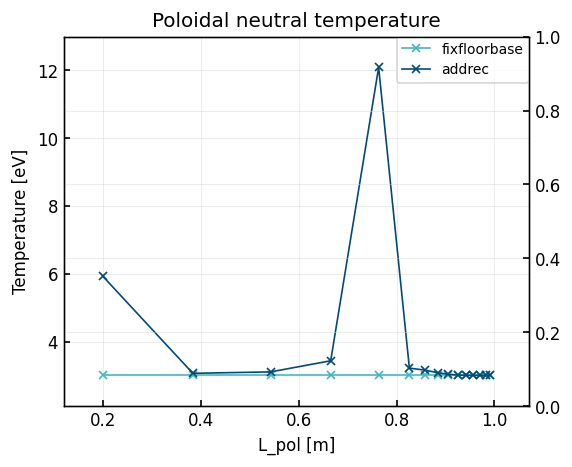

In [3]:

# colors = mpl.cm.get_cmap("plasma", len(cases))(range(len(cases)))
fig, ax = plt.subplots(dpi = 120)

cases = cs.keys()

ax2 = ax.twinx()

# colors = ["teal", "darkorange", "firebrick"]

for i, case in enumerate(cases):
    ds = cs[case].ds.isel(t=-1)
    m = ds.metadata
    fl = ds.isel(x = m["ixseps1"], theta = slice(41,-2))
    dist = np.cumsum(fl["dl"])
    
    if any([x in case for x in ["form2", "form4"]]):
        marker = "x"
    elif any([x in case for x in ["form1", "form3"]]):
        marker = "+"
    else:
        marker = "x"
    ax.plot(dist, fl["Td"], label = case, marker = marker, ms = 5, lw = 1, 
            # color = colors[i]
            )
    
    # try:
    # try:
    #     ax2.plot(dist, fl["Sd+_rec"], label = case, marker = marker, ms = 5, lw = 1)
    # except:
    #     pass
                # color = colors[i])
# ax.plot(dist, fl["Td+"],  marker = "o", ms = 5, lw = 0.5, c = colors[i])
# ax.set_yscale("symlog", linthresh = 1e-3)
ax.set_xlabel("L_pol [m]")
ax.set_ylabel("Temperature [eV]")
ax.set_title("Poloidal neutral temperature")
ax.legend(fontsize="small")
# ax.set_ylim(0,200)

## Field line history

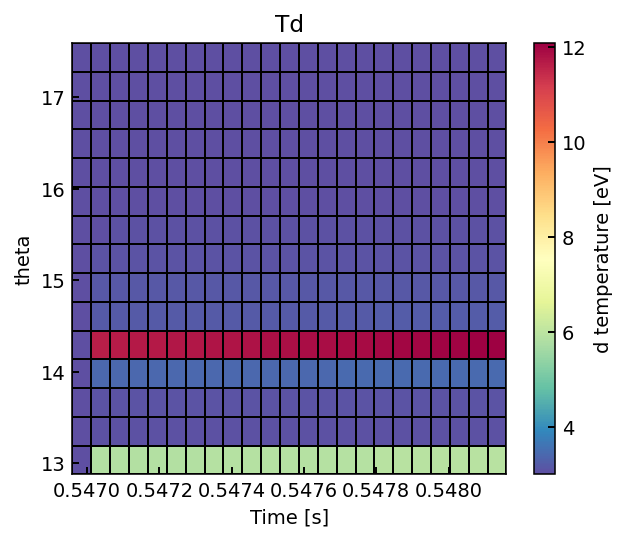

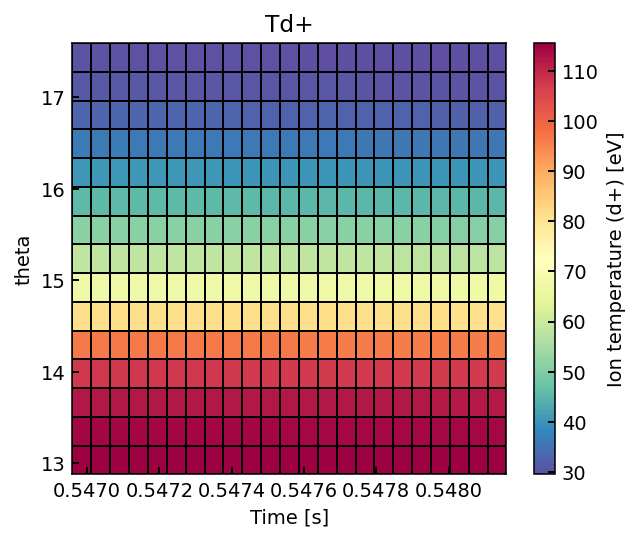

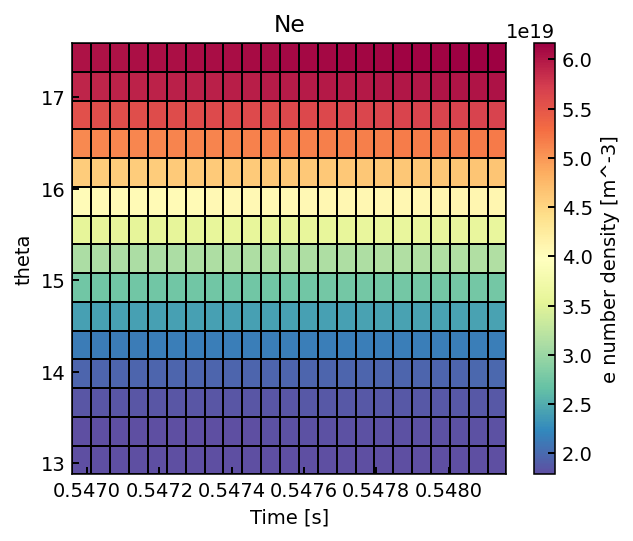

In [4]:
ds = cs["addrec"].ds
m = ds.metadata
fl = ds.isel(x = m["ixseps1"], theta = slice(41,-2))

for param in ["Td", "Td+", "Ne"]:
    fl[param].plot(cmap = "Spectral_r", linewidth = 0.01, color = "k", x = "t")
    plt.grid(False)
    plt.title(param)
    plt.show()

## Core history

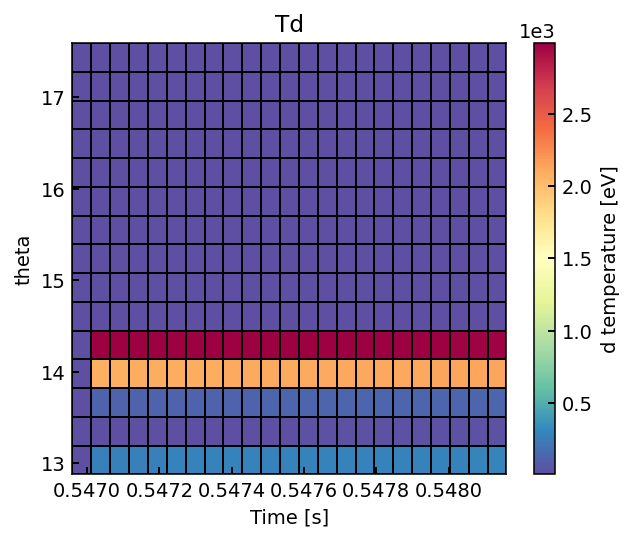

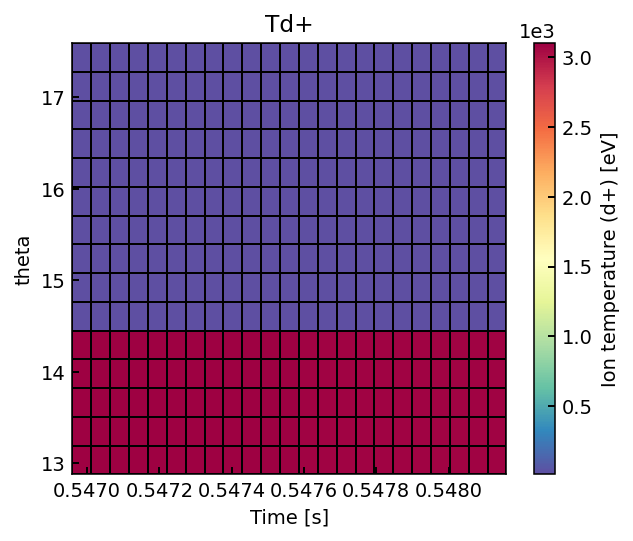

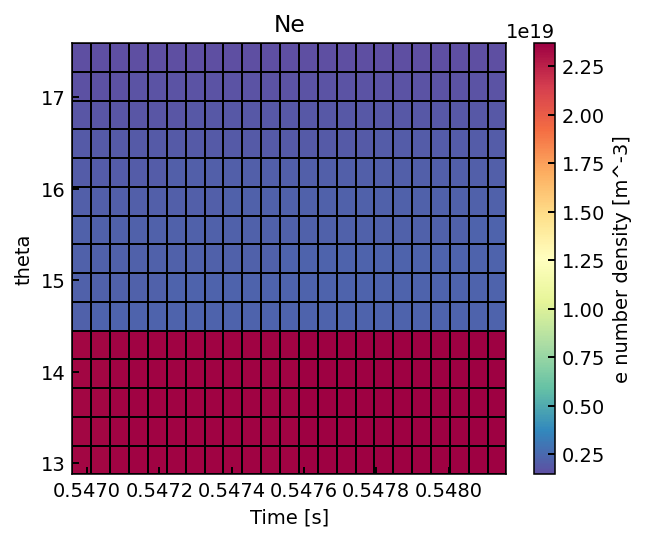

In [5]:
ds = cs["addrec"].ds
m = ds.metadata
fl = ds.isel(x = 2, theta = slice(41,-2))

for param in ["Td", "Td+", "Ne"]:
    fl[param].plot(cmap = "Spectral_r", linewidth = 0.01, color = "k", x = "t")
    plt.grid(False)
    plt.title(param)
    plt.show()

# Lineplot compare

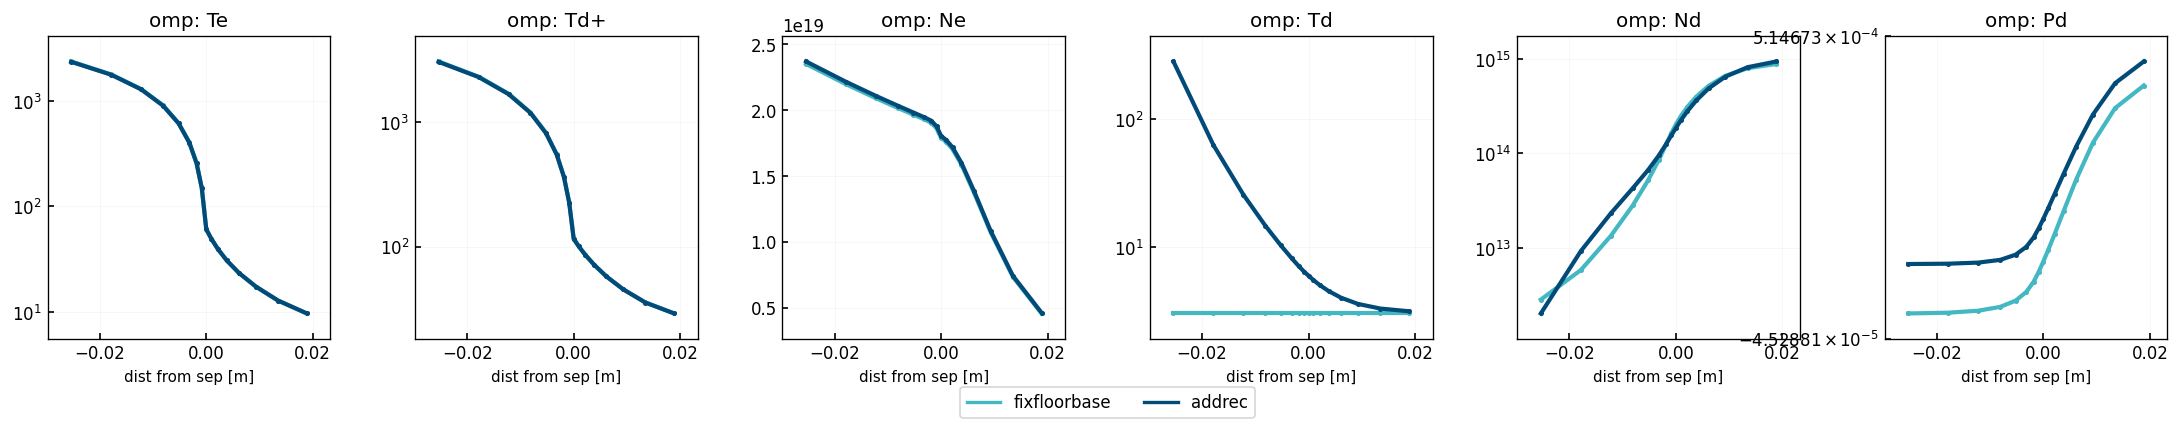

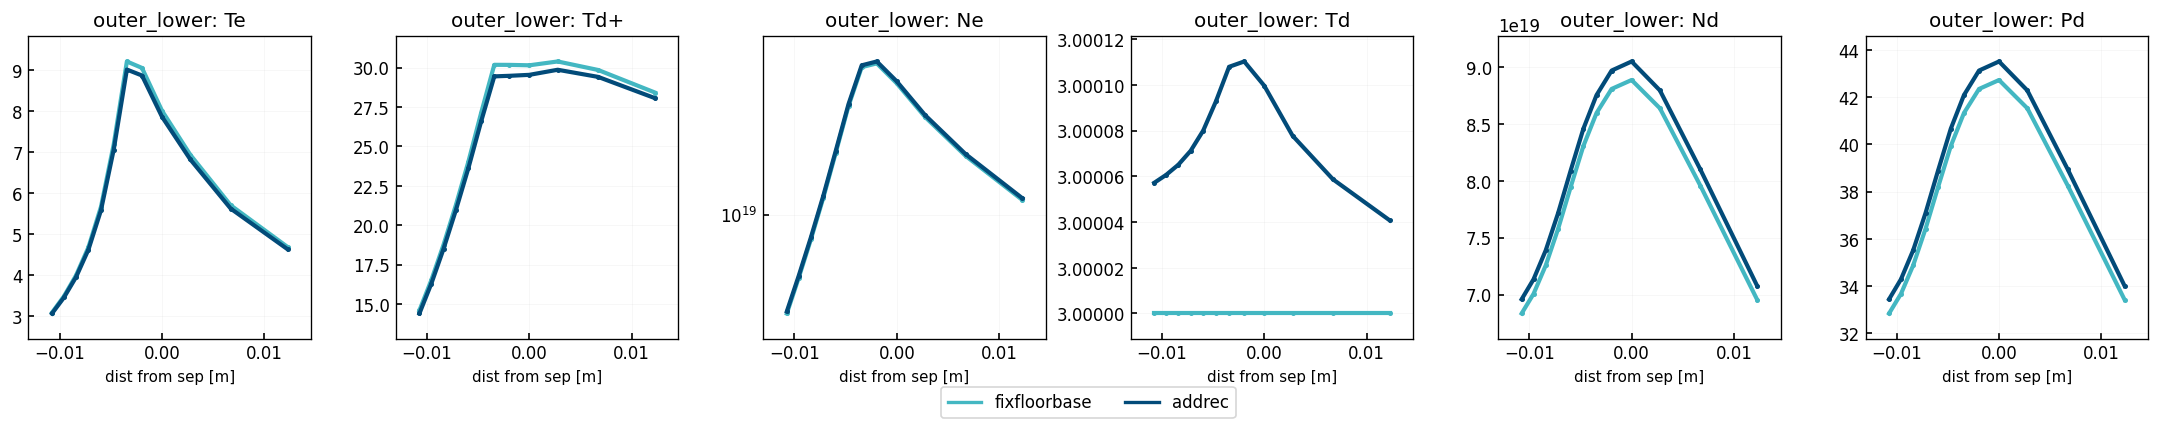

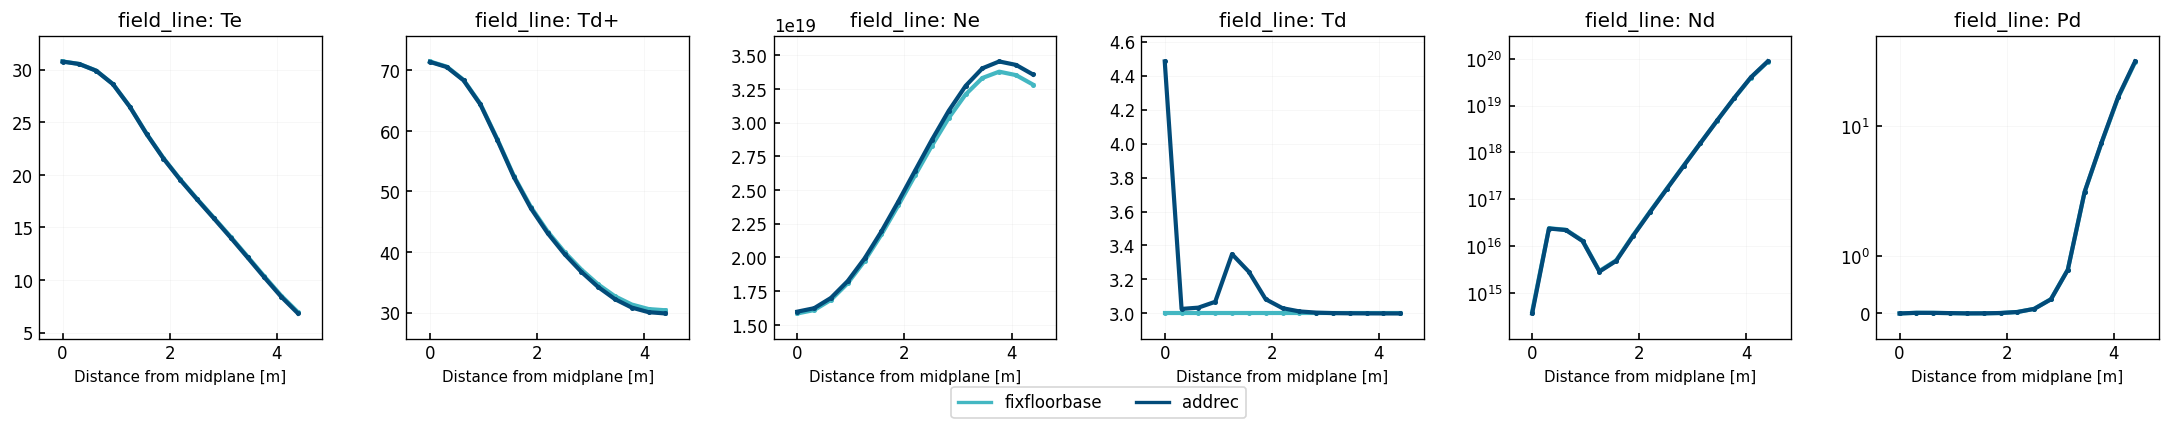

In [6]:
toplot = {}
for case in cs:
    toplot[case] = cs[case].ds.isel(t=-1, x = slice(2,-2))
    
lineplot(
    toplot,
    clean_guards = False,
    logscale = True,
    params = ["Te", "Td+", "Ne", "Td", "Nd", "Pd"],
    regions = ["omp", "outer_lower", "field_line"],
)

# 2D plotting

In [42]:
%matplotlib widget

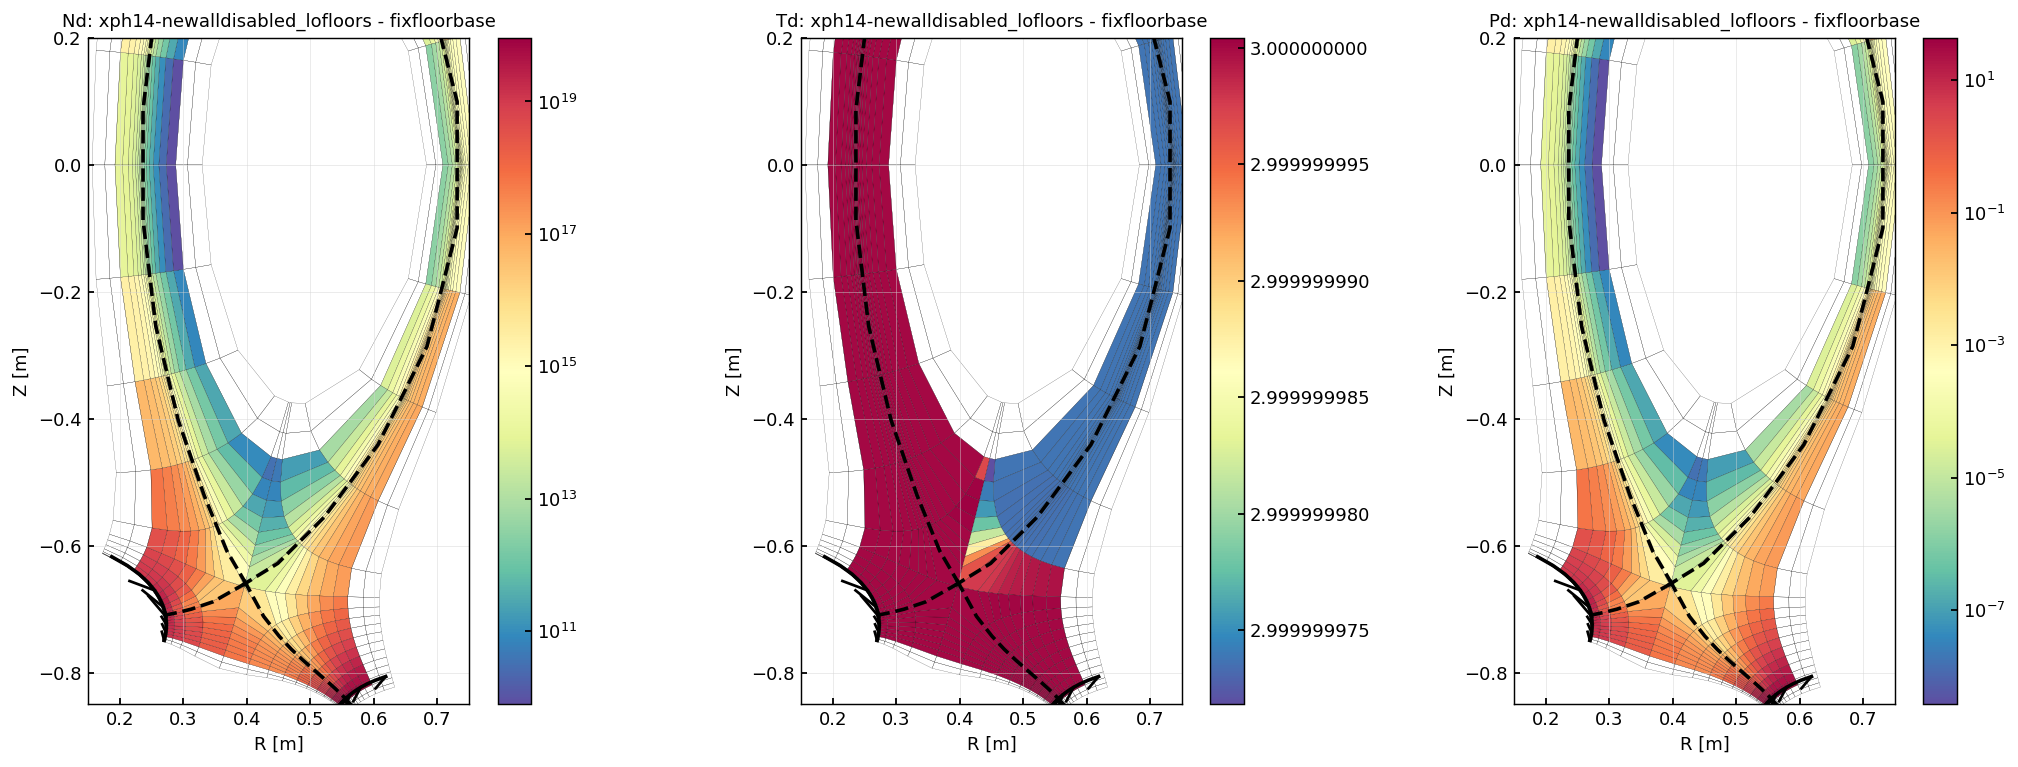

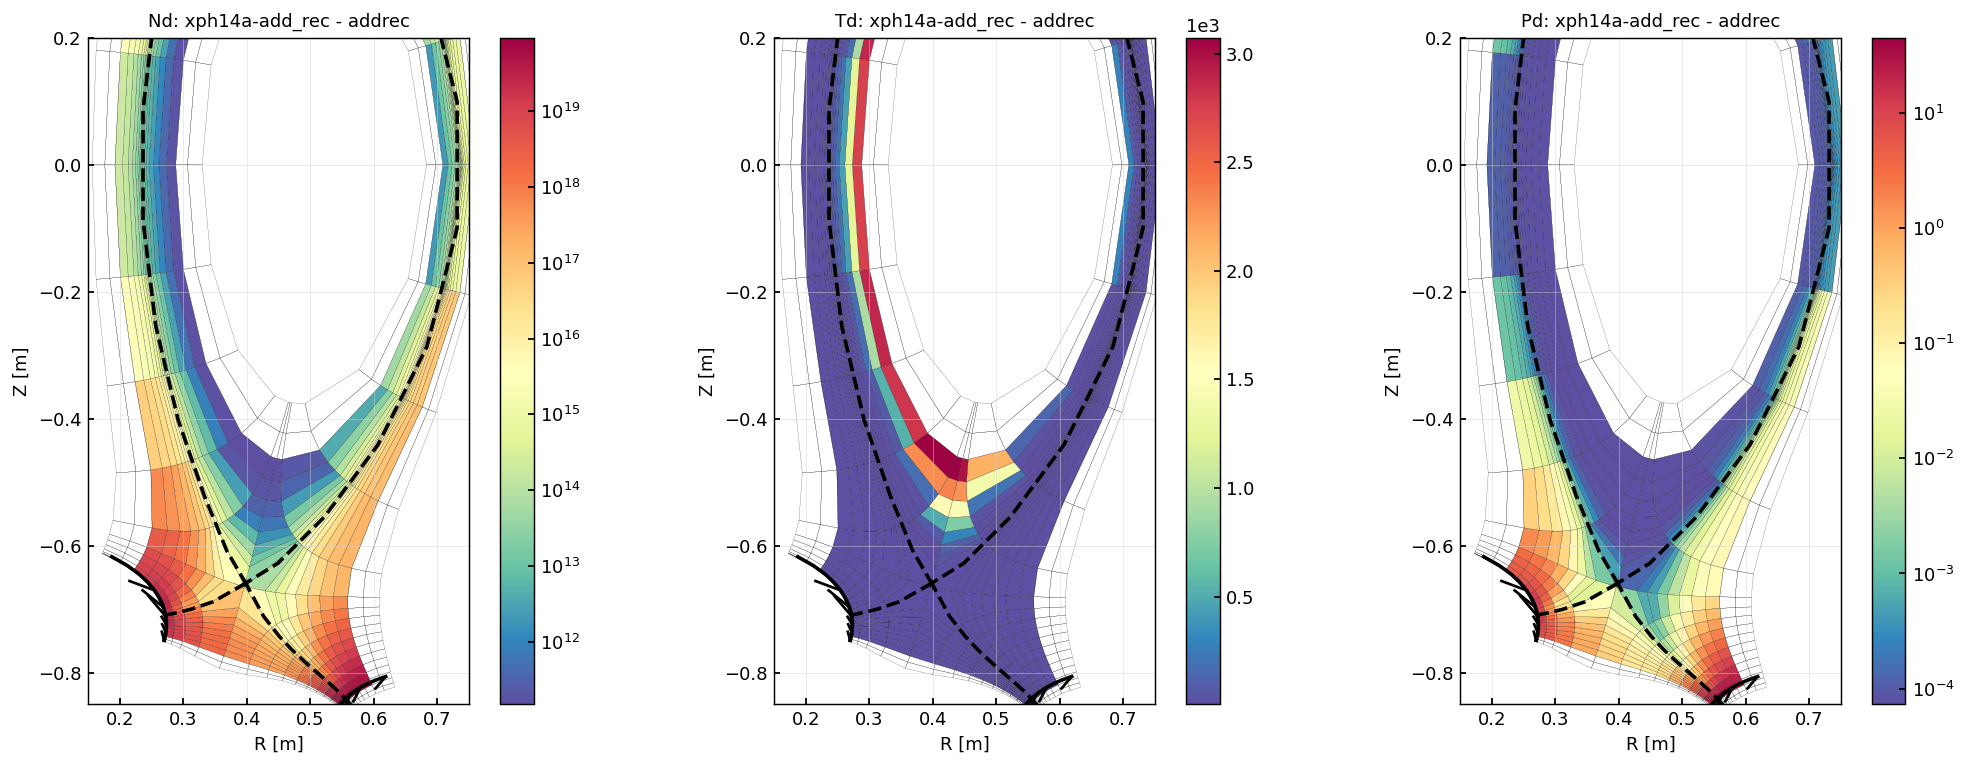

In [13]:
clean_guards = True

for entry in toload:
    case = entry["name"]
    fig, axes = plt.subplots(1,3, figsize = (16,6), dpi = 130)
    newds = cs[case].ds.isel(t=-1)
    
    ax = axes[0]
    data = (newds["Nd"])
    if clean_guards:
        data = data.hermesm.clean_guards()
    data.bout.polygon(ax, cmap = "Spectral_r", 
                                        # vmax = 25, vmin = 300, 
                                        antialias = True, linewidth = 0.1, logscale = True)
    ax.set_ylim(-0.85, 0.2)
    ax.set_xlim(0.15,0.75)
    ax.set_title(f"Nd: {entry['id']} - {entry['name']}", fontsize = "medium")
    
    
    ax = axes[1]
    data = (newds["Td"])
    if clean_guards:
        data = data.hermesm.clean_guards()
    data.bout.polygon(ax, cmap = "Spectral_r", 
                                        # vmax = 25, vmin = 300, 
                                        antialias = True, linewidth = 0.1, logscale = False)
    ax.set_ylim(-0.85, 0.2)
    ax.set_xlim(0.15,0.75)
    ax.set_title(f"Td: {entry['id']} - {entry['name']}", fontsize = "medium")
    
    
    ax = axes[2]
    data = (newds["Pd"])
    if clean_guards:
        data = data.hermesm.clean_guards()
    data.bout.polygon(ax, cmap = "Spectral_r", 
                                        # vmax = 25, vmin = 300, 
                                        antialias = True, linewidth = 0.1, logscale = True)
    ax.set_ylim(-0.85, 0.2)
    ax.set_xlim(0.15,0.75)
    ax.set_title(f"Pd: {entry['id']} - {entry['name']}", fontsize = "medium")
    
    fig.tight_layout()


# Floor check

In [20]:
cs.keys()

dict_keys(['fixfloorbase', 'addrec'])

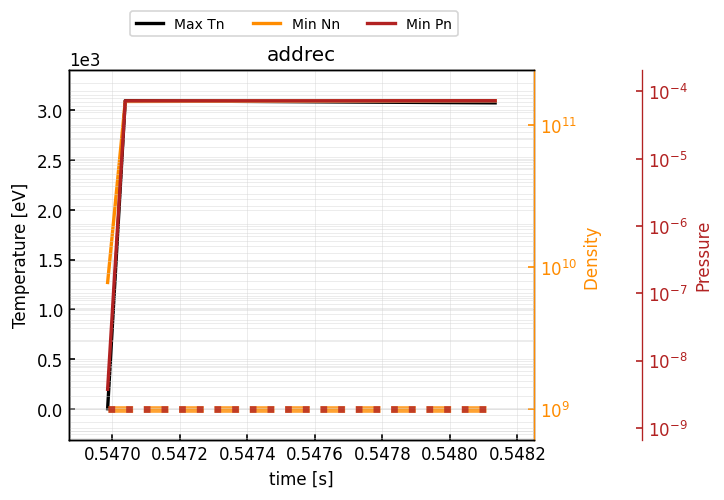

In [22]:

colors = ["teal", "darkorange", "firebrick", "navy", "limegreen", "purple", "skyblue", "red"]
name = "addrec"

# colors = mpl.cm.get_cmap("plasma", len(cases))(range(len(cases)))
fig, ax = plt.subplots(dpi = 120)

ds = cs[name].ds
m = ds.metadata
floors = ds.hermesm.get_floors()

ax.plot(ds["t"], ds["Td"].hermesm.clean_guards().max(["x", "theta"]), label = "Max Tn", marker = "x", ms = 0, lw = 2, color = "k")

# ax.set_yscale("symlog", linthresh = 1e-3)
# ax.set_yscale("log")
ax.set_xlabel("time [s]")
ax.set_ylabel("Temperature [eV]")
ax.set_title(name)

ax2 = ax.twinx()
ax2color = "darkorange"
ax2.plot(ds["t"], ds["Nd"].hermesm.clean_guards().min(["x", "theta"]), label = "Min Nn", c = ax2color, marker = "x", ms = 0, lw = 2)
ax2.set_yscale("log")
# ax2.set_ylim(1e14,3e17)
ax2.set_ylabel("Density ", color = ax2color)
ax2.spines["right"].set_color(ax2color)
ax2.tick_params(axis = "y", colors = ax2color)
ax2.plot(ds["t"], np.ones_like(ds["t"])*floors["nn_floor_si"], c = ax2color, ls = "--", zorder = 100, lw = 4, alpha = 0.8)

ax3 = ax.twinx()
ax3color = "firebrick"
ax3.plot(ds["t"], ds["Pd"].hermesm.clean_guards().min(["x", "theta"]), label = "Min Pn", c = ax3color, marker = "x", ms = 0, lw = 2)
ax3.set_yscale("log")
# ax3.set_ylim(0.0001,10)
ax3.set_ylabel("Pressure", color = ax3color)
ax3.spines["right"].set_color(ax3color)
ax3.spines["right"].set_position(("outward", 65))
ax3.tick_params(axis = "y", colors = ax3color)
ax3.plot(ds["t"], np.ones_like(ds["t"])*floors["pn_floor_si"], c = ax3color, ls = ":", zorder = 100, lw = 4, alpha = 0.8)


fig.legend(loc = "lower center", bbox_to_anchor = (0.5, 0.95), ncols = 4, fontsize="small")
ax.grid(which = "minor", visible = False)
# ax.set_yscale("log")
# ax.set_ylim(10,10000)

# Balances

## Calculate

In [5]:
for name in cs:
    ds = cs[name].ds
    #### PARTICLE FLOW
    ds["pfXlo"] = ds["ParticleFlow_d_xlow"]
    ds["pfXhi"] = ds["pfXlo"].shift(x=-1)
    ds["pfYlo"] = ds["ParticleFlow_d_ylow"]
    ds["pfYhi"] = ds["pfYlo"].shift(theta=-1)

    ds["pfXnet"] = ds["pfXlo"] - ds["pfXhi"]
    ds["pfYnet"] = ds["pfYlo"] - ds["pfYhi"]
    ds["pfNet"] = ds["pfXnet"] + ds["pfYnet"]

    ds["pfSrc"] = ds["Sd+_iz"]*ds["dv"]*-1  + ds["Sd_target_recycle"]*ds["dv"]

    if "Sd+_rec" in ds.data_vars:
        ds["pfSrc"] += ds["Sd+_rec"]*ds["dv"]*-1
    if "Sd_wall_recycle" in ds.data_vars:
        ds["pfSrc"] += ds["Sd_wall_recycle"]*ds["dv"]
    if "Sd_src" in ds.data_vars:
        ds["pfSrc"] += ds["Sd_src"]*ds["dv"]


    ds["pfBal"] = ds["pfSrc"] + ds["pfNet"]

    #### ENERGY FLOW
    ds["efXlo"] = ds["EnergyFlow_d_xlow"]
    ds["efXhi"] = ds["efXlo"].shift(x=-1)
    ds["efYlo"] = ds["EnergyFlow_d_ylow"]
    ds["efYhi"] = ds["efYlo"].shift(theta=-1)

    ds["efXnet"] = ds["efXlo"] - ds["efXhi"]
    ds["efYnet"] = ds["efYlo"] - ds["efYhi"]
    ds["efNet"] = ds["efXnet"] + ds["efYnet"]


    ds["efSrc"] = ds["Ed+_iz"]*ds["dv"]*-1  + ds["Ed_target_recycle"]*ds["dv"]

    if "Ed+_rec" in ds.data_vars:
        ds["efSrc"] += ds["Ed+_rec"]*ds["dv"]*-1
    if "Ed_wall_recycle" in ds.data_vars:
        ds["efSrc"] += ds["Ed_wall_recycle"]*ds["dv"]
    if "Ed_target_refl" in ds.data_vars:
        ds["efSrc"] += ds["Ed_target_refl"]*ds["dv"]
    if "Pd_src" in ds.data_vars:
        ds["efSrc"] += ds["Pd_src"]*ds["dv"] * 3/2

    cs[name].ds = ds
# ds["pfSrc"] = ds["Sd+_iz"]*ds["dv"]*-1  + ds["Sd_target_recycle"]*ds["dv"]

## 2D plot

fixfloorbase
addrec


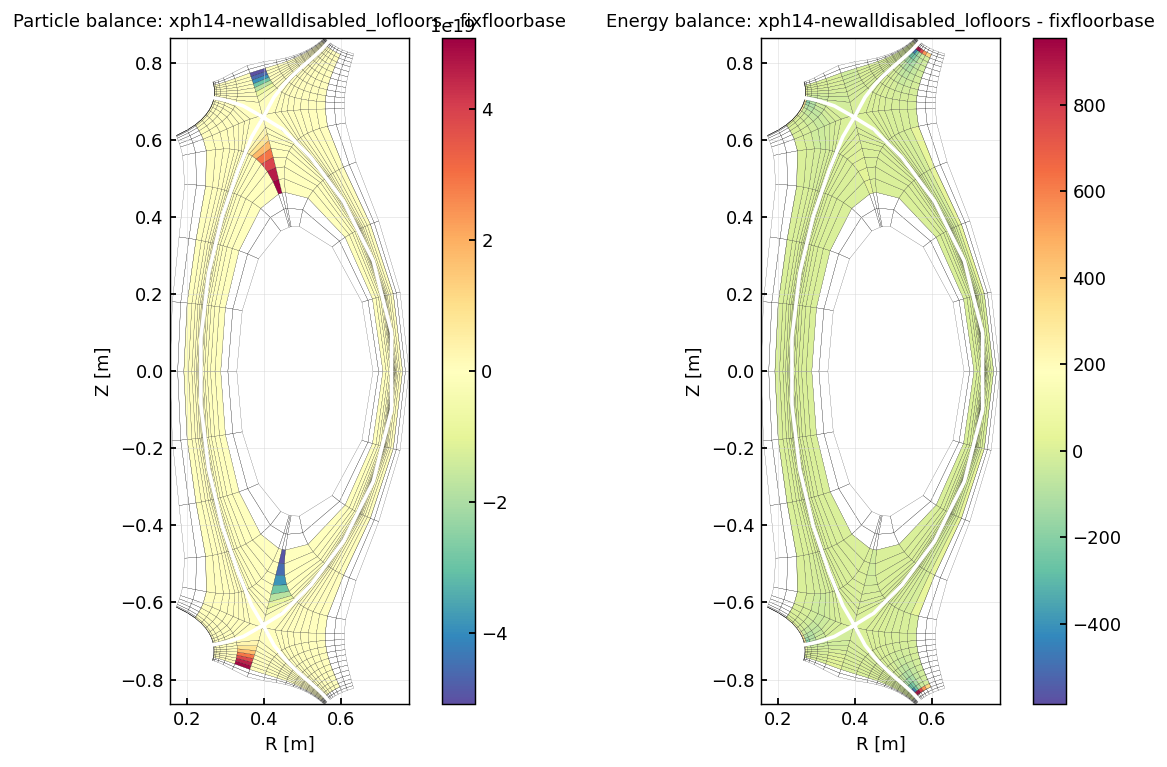

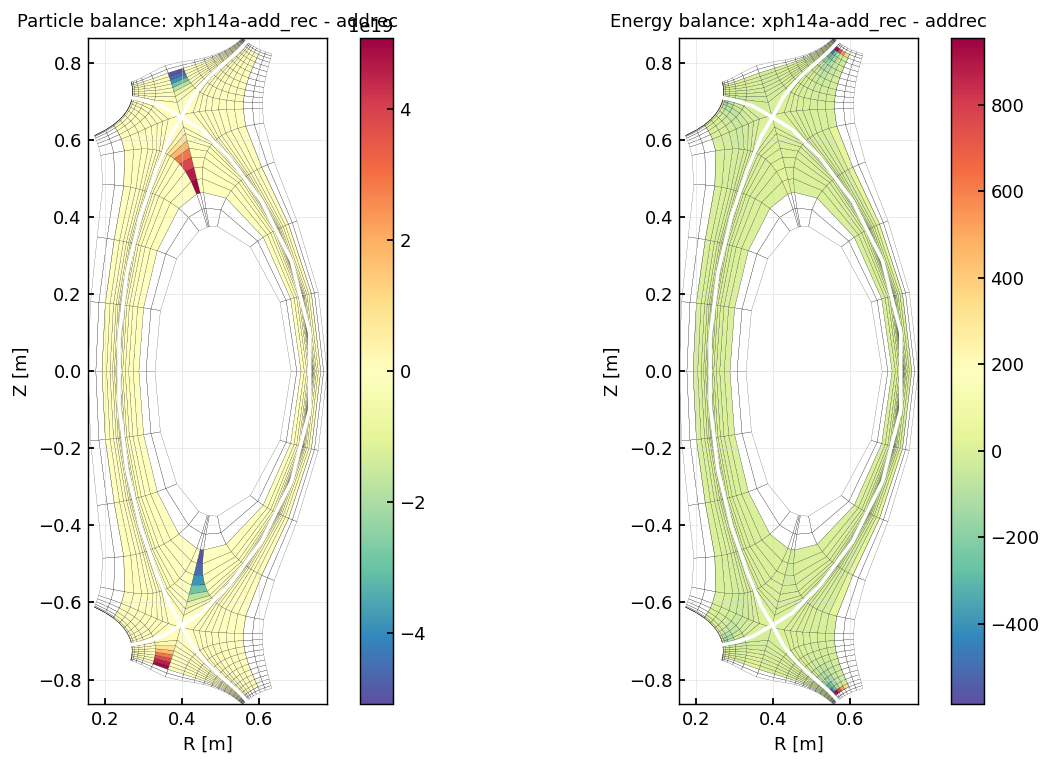

In [8]:
clean_guards = True

for entry in toload:
    case = entry["name"]
    fig, axes = plt.subplots(1,2, figsize = (10,6), dpi = 130)
    print(case)
    newds = cs[case].ds.isel(t=-1)
    
    ax = axes[0]
    # data = (ds["pfNet"] + ds["pfSrc"]) / ds["pfSrc"]
    data = (ds["pfNet"] + ds["pfSrc"])
    if clean_guards:
        data = data.hermesm.clean_guards()
    data.bout.polygon(ax, cmap = "Spectral_r", targets = False,
                                        separatrix_kwargs = dict(color="white", linestyle = "-", linewidth = 2),
                                        # vmax = 1, vmin = -1, 
                                        antialias = True, linewidth = 0.1, logscale = False)

    ax.set_title(f"Particle balance: {entry['id']} - {entry['name']}", fontsize = "medium")
    
    
    ax = axes[1]
    # data = data = (ds["efNet"] + ds["efSrc"]) / ds["efSrc"]
    data = (ds["efNet"] + ds["efSrc"]) 
    if clean_guards:
        data = data.hermesm.clean_guards()
    data.bout.polygon(ax, cmap = "Spectral_r", targets = False,
                                        separatrix_kwargs = dict(color="white", linestyle = "-", linewidth = 2),
                                        # vmax = 1, vmin = -1, 
                                        antialias = True, linewidth = 0.1, logscale = False)
    
    ax.set_title(f"Energy balance: {entry['id']} - {entry['name']}", fontsize = "medium")
    
    
    fig.tight_layout()
    
    # for ax in axes:
        # ax.set_ylim(-0.85, 0.2)
        # ax.set_xlim(0.15,0.75)


## IMP

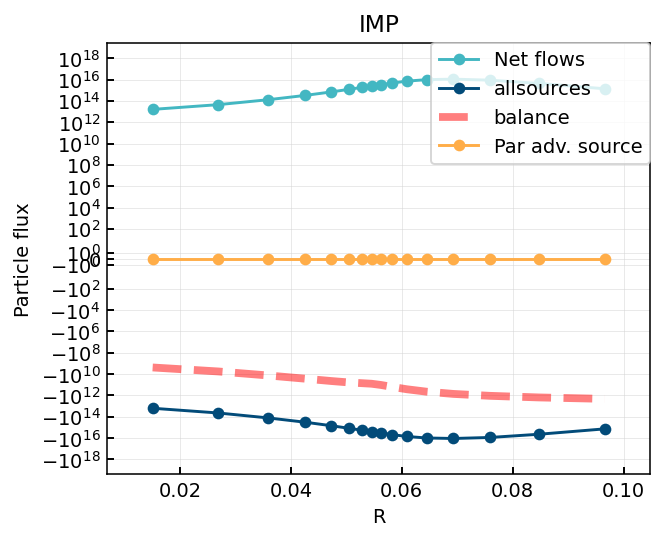

In [34]:
# reg = ds.hermesm.select_custom_sol_ring(11, region = "outer_lower").squeeze().isel(theta = slice(None, None))

ds = cs["fixfloorbase"].ds.isel(t=-1)
reg = ds.hermesm.select_region("inner_midplane_a").isel(x = slice(2,-2))
title = "IMP"

fig, ax = plt.subplots()
x = np.cumsum(reg["dr"]).values
kwargs = dict(marker = "o", ms = 5)

# ax.plot(x, reg["pfXnet"], label = "pfXnet", **kwargs)
# ax.plot(x, reg["pfYnet"], label = "pfYnet", **kwargs)
ax.plot(x, reg["pfNet"], label = "Net flows", **kwargs)
# ax.plot(x, reg["Sd+_iz"]*reg["dv"]*-1, label = "iz", **kwargs)

ax.plot(x, reg["pfSrc"], label = "allsources", **kwargs)
ax.plot(x, (reg["pfNet"] + reg["pfSrc"]), label = "balance", c = "r", ls = "--", lw = 4, alpha = 0.5)
# ax.plot(x, reg["ddt(Nd)"], label = "ddt(Nd)", c = "r", lw = 4, alpha = 0.5)
# ax.plot(x, reg["Sd_perp_adv"]*reg["dv"]*-1, label = "Perp adv. source",  **kwargs)
ax.plot(x, reg["Sd_par_adv"]*reg["dv"], label = "Par adv. source",  **kwargs)

# ax.plot(x, reg["Sd+_rec"]*reg["dv"]*-1, label = "rec", **kwargs)

ax.legend()
ax.set_xlabel("R")
ax.set_ylabel("Particle flux")
ax.set_title(title)
ax.set_yscale("symlog")
ax.set_xscale("linear")
# ax.set_xlim(0.8, None)

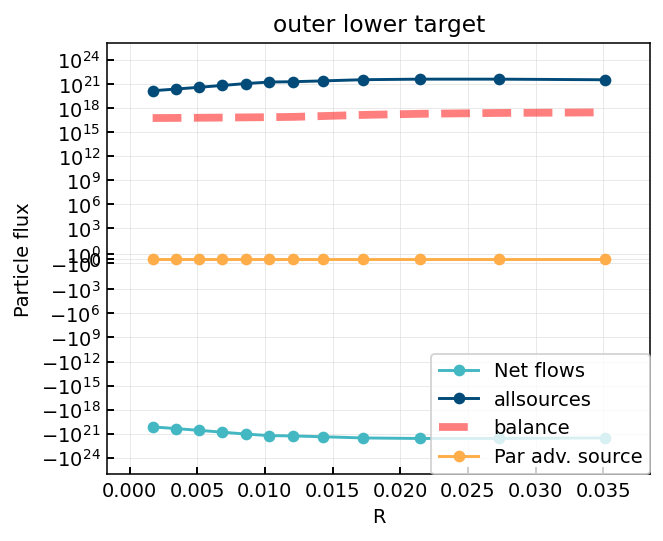

In [11]:
# reg = ds.hermesm.select_custom_sol_ring(11, region = "outer_lower").squeeze().isel(theta = slice(None, None))
reg = ds.hermesm.select_region("outer_lower_target").isel(x = slice(2,-2), t = -1).squeeze()
title = "outer lower target"

fig, ax = plt.subplots()
x = np.cumsum(reg["dr"]).values
kwargs = dict(marker = "o", ms = 5)

# ax.plot(x, reg["pfXnet"], label = "pfXnet", **kwargs)
# ax.plot(x, reg["pfYnet"], label = "pfYnet", **kwargs)
ax.plot(x, reg["pfNet"], label = "Net flows", **kwargs)
# ax.plot(x, reg["Sd+_iz"]*reg["dv"]*-1, label = "iz", **kwargs)

ax.plot(x, reg["pfSrc"], label = "allsources", **kwargs)
ax.plot(x, reg["pfNet"] + reg["pfSrc"], label = "balance", c = "r", ls = "--", lw = 4, alpha = 0.5)
# ax.plot(x, reg["ddt(Nd)"], label = "ddt(Nd)", c = "r", lw = 4, alpha = 0.5)
# ax.plot(x, reg["Sd_perp_adv"]*reg["dv"]*-1, label = "Perp adv. source",  **kwargs)
ax.plot(x, reg["Sd_par_adv"]*reg["dv"], label = "Par adv. source",  **kwargs)

# ax.plot(x, reg["Sd+_rec"]*reg["dv"]*-1, label = "rec", **kwargs)

ax.legend()
ax.set_xlabel("R")
ax.set_ylabel("Particle flux")
ax.set_title(title)
ax.set_yscale("symlog")
ax.set_xscale("linear")
# ax.set_xlim(0.8, None)

## Target

### PF

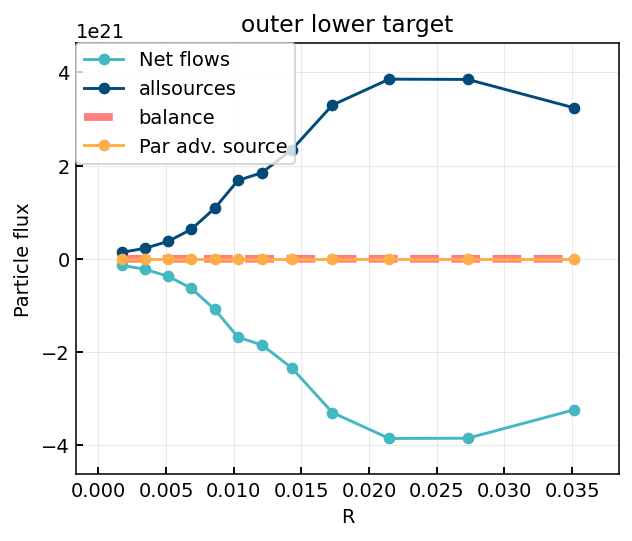

In [49]:
# reg = ds.hermesm.select_custom_sol_ring(11, region = "outer_lower").squeeze().isel(theta = slice(None, None))
reg = ds.hermesm.select_region("outer_lower_target").isel(x = slice(2,-2))
title = "outer lower target"

fig, ax = plt.subplots()
x = np.cumsum(reg["dr"]).values
kwargs = dict(marker = "o", ms = 5)

# ax.plot(x, reg["pfXnet"], label = "pfXnet", **kwargs)
# ax.plot(x, reg["pfYnet"], label = "pfYnet", **kwargs)
ax.plot(x, reg["pfNet"], label = "Net flows", **kwargs)
# ax.plot(x, reg["Sd+_iz"]*reg["dv"]*-1, label = "iz", **kwargs)

ax.plot(x, reg["pfSrc"], label = "allsources", **kwargs)
ax.plot(x, reg["pfNet"] + reg["pfSrc"], label = "balance", c = "r", ls = "--", lw = 4, alpha = 0.5)
# ax.plot(x, reg["ddt(Nd)"], label = "ddt(Nd)", c = "r", lw = 4, alpha = 0.5)
# ax.plot(x, reg["Sd_perp_adv"]*reg["dv"]*-1, label = "Perp adv. source",  **kwargs)
ax.plot(x, reg["Sd_par_adv"]*reg["dv"], label = "Par adv. source",  **kwargs)

# ax.plot(x, reg["Sd+_rec"]*reg["dv"]*-1, label = "rec", **kwargs)

ax.legend()
ax.set_xlabel("R")
ax.set_ylabel("Particle flux")
ax.set_title(title)
# ax.set_yscale("symlog")
ax.set_xscale("linear")
# ax.set_xlim(0.8, None)

### EF

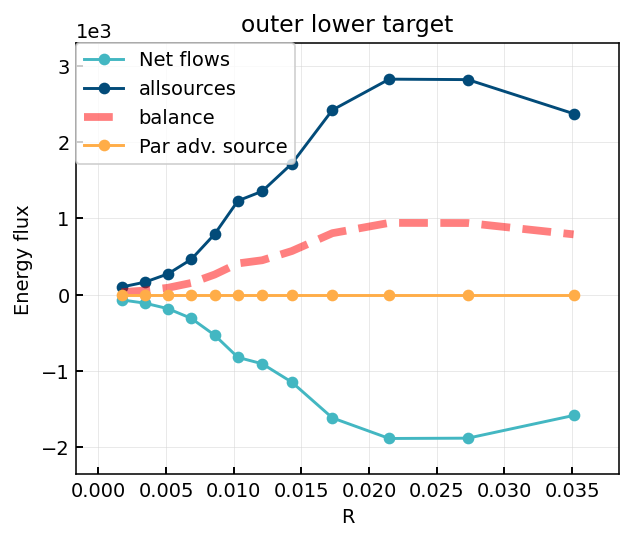

In [13]:
# reg = ds.hermesm.select_custom_sol_ring(11, region = "outer_lower").squeeze().isel(theta = slice(None, None))

if "t" in ds.dims:
    ds = ds.isel(t=-1)
    
reg = ds.hermesm.select_region("outer_lower_target").isel(x = slice(2,-2)).squeeze()
title = "outer lower target"

fig, ax = plt.subplots()
x = np.cumsum(reg["dr"]).values
kwargs = dict(marker = "o", ms = 5)

# ax.plot(x, reg["efXnet"], label = "pfXnet", **kwargs)
# ax.plot(x, reg["efYnet"], label = "pfYnet", **kwargs)
ax.plot(x, reg["efNet"], label = "Net flows", **kwargs)
# ax.plot(x, reg["Sd+_iz"]*reg["dv"]*-1, label = "iz", **kwargs)

ax.plot(x, reg["efSrc"], label = "allsources", **kwargs)
ax.plot(x, reg["efNet"] + reg["efSrc"], label = "balance", c = "r", ls = "--", lw = 4, alpha = 0.5)
# ax.plot(x, reg["ddt(Nd)"], label = "ddt(Nd)", c = "r", lw = 4, alpha = 0.5)
# ax.plot(x, reg["Sd_perp_adv"]*reg["dv"]*-1, label = "Perp adv. source",  **kwargs)
ax.plot(x, reg["Sd_par_adv"]*reg["dv"], label = "Par adv. source",  **kwargs)

# ax.plot(x, reg["Sd+_rec"]*reg["dv"]*-1, label = "rec", **kwargs)

ax.legend()
ax.set_xlabel("R")
ax.set_ylabel("Energy flux")
ax.set_title(title)
# ax.set_yscale("symlog")
ax.set_xscale("linear")
# ax.set_xlim(0.8, None)

## Field line

### PF

(0.4, 1.0059875278358512)

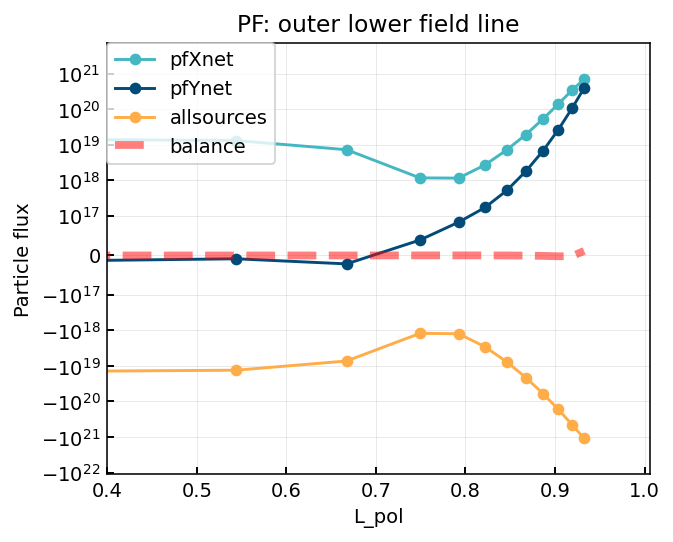

In [21]:
reg = ds.hermesm.select_custom_sol_ring(11, region = "outer_lower").squeeze().isel(theta = slice(None,-2))
title = "PF: outer lower field line"

fig, ax = plt.subplots()
x = np.cumsum(reg["dl"]).values
kwargs = dict(marker = "o", ms = 5)

ax.plot(x, reg["pfXnet"], label = "pfXnet", **kwargs)
ax.plot(x, reg["pfYnet"], label = "pfYnet", **kwargs)
# ax.plot(x, reg["pfNet"], label = "Net flows", **kwargs)
# ax.plot(x, reg["Sd+_iz"]*reg["dv"]*-1, label = "iz", **kwargs)

ax.plot(x, reg["pfSrc"], label = "allsources", **kwargs)
ax.plot(x, reg["pfNet"] + reg["pfSrc"], label = "balance", c = "r", ls = "--", lw = 4, alpha = 0.5)
# ax.plot(x, reg["ddt(Nd)"], label = "ddt(Nd)", c = "r", lw = 4, alpha = 0.5)
# ax.plot(x, reg["Sd_perp_adv"]*reg["dv"]*-1, label = "Perp adv. source",  **kwargs)
# ax.plot(x, reg["Sd_par_adv"]*reg["dv"], label = "Par adv. source",  **kwargs)

# ax.plot(x, reg["Sd+_rec"]*reg["dv"]*-1, label = "rec", **kwargs)

ax.legend()
ax.set_xlabel("L_pol")
ax.set_ylabel("Particle flux")
ax.set_yscale("symlog", linthresh = 1e17)
ax.set_title(title)
ax.set_xlim(0.4, None)

### EF

(0.4, 1.0288331727062188)

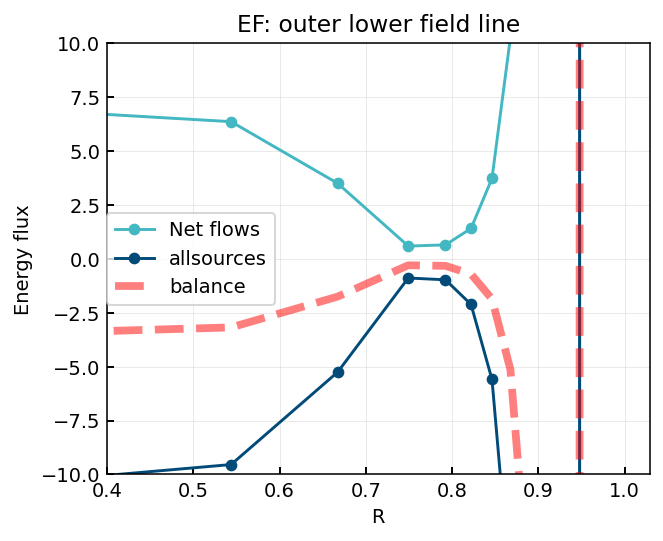

In [6]:
ds = cs["addrec"].ds

if "t" in ds.dims:
    ds = ds.isel(t=-1)

reg = ds.hermesm.select_custom_sol_ring(11, region = "outer_lower").squeeze()
title = "EF: outer lower field line"

fig, ax = plt.subplots()
x = np.cumsum(reg["dl"]).values
kwargs = dict(marker = "o", ms = 5)

# ax.plot(x, reg["pfXnet"], label = "pfXnet", **kwargs)
# ax.plot(x, reg["pfYnet"], label = "pfYnet", **kwargs)
ax.plot(x, reg["efNet"], label = "Net flows", **kwargs)
# ax.plot(x, reg["Sd+_iz"]*reg["dv"]*-1, label = "iz", **kwargs)

ax.plot(x, reg["efSrc"], label = "allsources", **kwargs)


ax.plot(x, reg["efNet"] + reg["efSrc"], label = "balance", c = "r", ls = "--", lw = 4, alpha = 0.5)
# ax.plot(x, reg["ddt(Nd)"], label = "ddt(Nd)", c = "r", lw = 4, alpha = 0.5)
# ax.plot(x, reg["Sd_perp_adv"]*reg["dv"]*-1, label = "Perp adv. source",  **kwargs)
# ax.plot(x, reg["Sd_par_adv"]*reg["dv"], label = "Par adv. source",  **kwargs)

# ax.plot(x, reg["Sd+_rec"]*reg["dv"]*-1, label = "rec", **kwargs)

ax.legend()
ax.set_xlabel("R")
ax.set_ylabel("Energy flux")
# ax.set_yscale("symlog")
ax.set_ylim(-10,10)
ax.set_title(title)
ax.set_xlim(0.4, None)

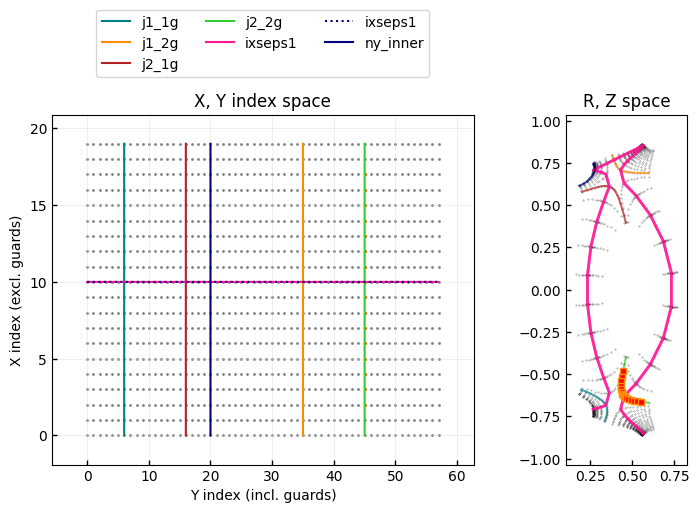

In [84]:
plot_selection(ds, ds.isel(x = slice(2,-2), theta = 45))

# Radial slice

Text(0.5, 1.0, 'EF: radial slice through spike')

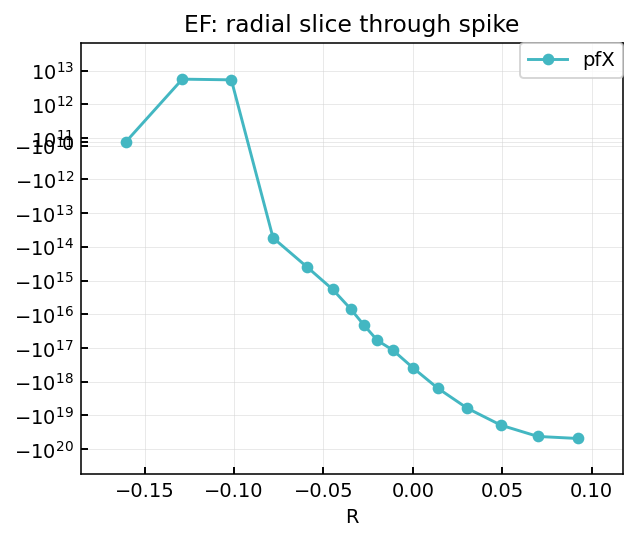

In [91]:
ds = cs["addrec"].ds

if "t" in ds.dims:
    ds = ds.isel(t=-1)

reg = ds.isel(x = slice(2,-2), theta = 45).squeeze()
title = "EF: radial slice through spike"

fig, ax = plt.subplots()
x = np.cumsum(reg["dr"]).values
x = x - x[ds.metadata["ixseps1"]]
kwargs = dict(marker = "o", ms = 5)
ax.plot(x, reg["pfXlo"], label = "pfX", **kwargs)
# ax.plot(x, reg["efXlo"], label = "hfX", **kwargs)
# ax.plot(x, reg["pfXnet"], label = "pfXnet", **kwargs)
# ax.plot(x, reg["pfYnet"], label = "pfYnet", **kwargs)
# ax.plot(x, reg["efNet"], label = "Net flows", **kwargs)
# ax.plot(x, reg["Td"], label = "Neutral temp", **kwargs)
# ax.plot(x, reg["Ed+_rec"], label = "Neutral temp", **kwargs)
# ax.plot(x, reg["efXnet"], label = "efXnet", **kwargs)
# ax.plot(x, reg["efYnet"], label = "Net flows in Y", **kwargs)
# ax.plot(x, np.gradient(reg["Pd"],x), label = "Neutral pressure", **kwargs)
# ax.plot(x, reg["Sd+_iz"]*reg["dv"]*-1, label = "iz", **kwargs)

# ax.plot(x, reg["efSrc"], label = "allsources", **kwargs)


# ax.plot(x, reg["efNet"] + reg["efSrc"], label = "balance", c = "r", ls = "--", lw = 4, alpha = 0.5)
# ax.plot(x, reg["ddt(Nd)"], label = "ddt(Nd)", c = "r", lw = 4, alpha = 0.5)
# ax.plot(x, reg["Sd_perp_adv"]*reg["dv"]*-1, label = "Perp adv. source",  **kwargs)
# ax.plot(x, reg["Sd_par_adv"]*reg["dv"], label = "Par adv. source",  **kwargs)

# ax.plot(x, reg["Sd+_rec"]*reg["dv"]*-1, label = "rec", **kwargs)

ax.legend()
ax.set_xlabel("R")
# ax.set_ylabel("Energy flux")
# ax.set_ylabel("Particle flux")
# ax.set_yscale("symlog", linthresh = 1e-4)
ax.set_yscale("symlog", linthresh = 1e12)
# ax.set_yscale("log")
# ax.set_ylim(-10,10)
ax.set_title(title)
# ax.set_xlim(0.4, None)

In [50]:
reg["efXnet"].values

array([-2.67399193e-03,  7.24608955e-04,  8.26511654e-03,  1.23350935e-02,
        1.27192309e-02,  1.58945851e-02,  2.54057466e-02,  4.35536003e-02,
        2.16238917e-02,  1.30290335e-01,  5.69146473e-01,  2.20475645e+00,
        6.41075711e+00,  1.08531998e+01,  2.98165337e+00, -2.32876514e+01])

Text(0.5, 0, 'L_pol')

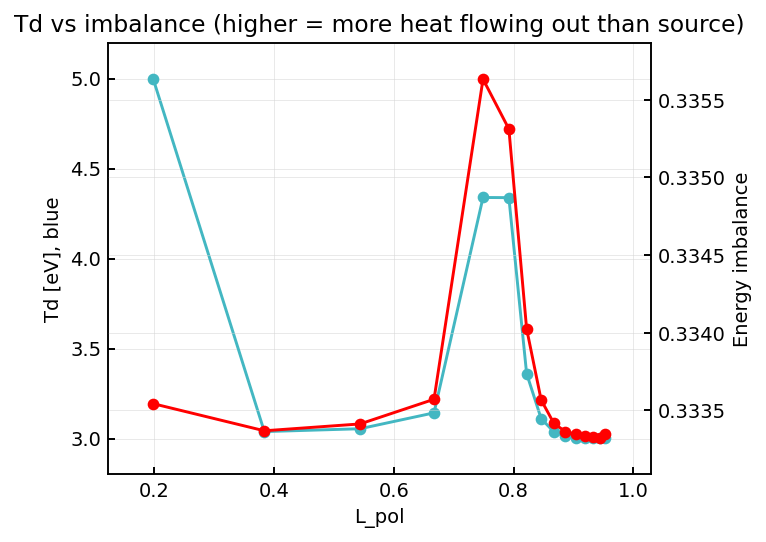

In [27]:
fig, ax = plt.subplots()
x = np.cumsum(reg["dl"]).values
kwargs = dict(marker = "o", ms = 5)

bal = (reg["efNet"] + reg["efSrc"]) / reg["efSrc"]

ax.plot(x, reg["Td"], label = "Td", **kwargs)
ax2 = ax.twinx()
ax2.plot(x, bal, c = "r", **kwargs)
ax.set_ylabel("Td [eV], blue")
ax2.set_ylabel("Energy imbalance")
ax.set_title("Td vs imbalance (higher = more heat flowing out than source)")
ax.set_xlabel("L_pol")

(-0.85, -0.4)

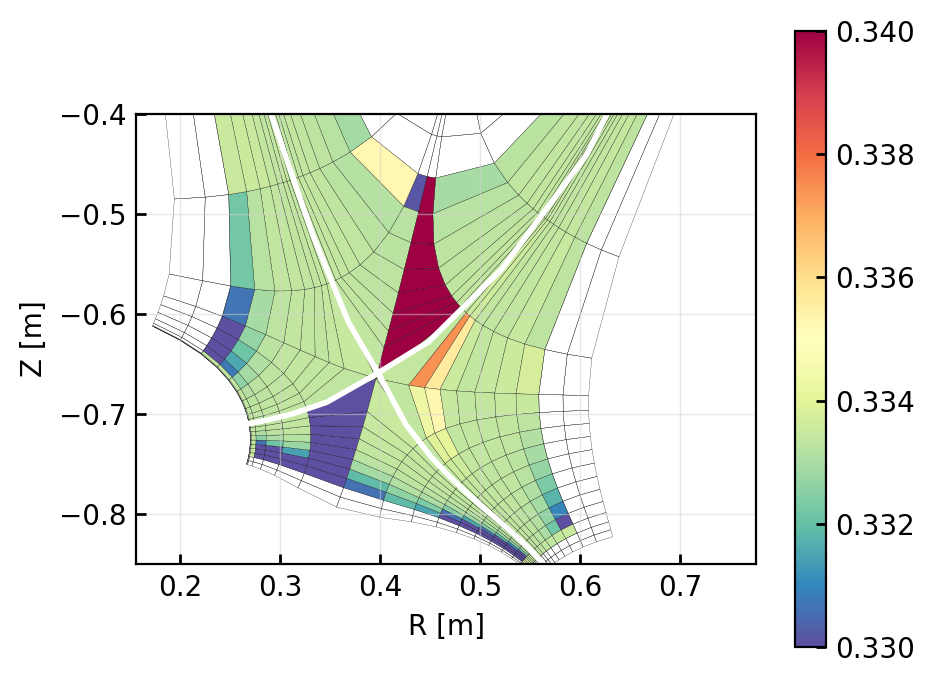

In [23]:
fig, ax = plt.subplots(dpi = 200)

ds = cs["addrec"].ds.isel(t=-1)
bal = (ds["efNet"] + ds["efSrc"]) / ds["efSrc"]

data = bal

data = data.hermesm.clean_guards()
data.bout.polygon(ax, cmap = "Spectral_r", targets = False,
                                    separatrix_kwargs = dict(color="white", linestyle = "-", linewidth = 2),
                                    vmax = 0.34, vmin = 0.33, 
                                    antialias = True, linewidth = 0.1, logscale = False)

ax.set_ylim(-0.85, -0.4)